In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import regex as re
from collections import Counter
import math

from google.colab import files
import zipfile
import glob

from brat_parser import get_entities_relations_attributes_groups

from nltk.tag import pos_tag, map_tag

from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec

from brat_parser import get_entities_relations_attributes_groups

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Neural network imports.
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input, Dropout
from keras.layers import TimeDistributed
from keras.layers import Concatenate
from keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Input

In [ ]:
# Import the premise positions in the articles for the IBM Debater dataset (premise-positions.txt).

uploaded = files.upload()

# Import the claims positions in the articles for the IBM Debater dataset (claim-positions.txt).

uploaded = files.upload()



Saving claim-positions.txt to claim-positions.txt


Saving premise-positions.txt to premise-positions.txt


In [ ]:
# Import the data relative to the sentences positions and statistics 
# (sentence_statistic.csv).
print('\nImport sentence_statistic.csv\n')
upload = files.upload()

# Import the data relative to the suvbjectivity score of the sentences and the Type Token Ratio.
# (remaining_stat.csv).
print('\nImport remaining_stat.csv\n')
upload = files.upload()

# Import the data relative to the sentences positions and statistics of the IBM Debater dataset
# (Debater_sentence_statistic.csv).
print('\nImport Debater_sentence_statistic.csv\n')
upload = files.upload()

# Import the data relative to the suvbjectivity score of the sentences and the Type Token Ratio.
# (remaining_stat.csv).
print('\nImport Debater_remaining_stat.csv\n')
upload = files.upload()


Import sentence_statistic.csv




Import remaining_stat.csv




Import Debater_sentence_statistic.csv




Import Debater_remaining_stat.csv



In [ ]:
# Import the IBM Debater dataset (2015 version).

uploaded = files.upload()

Saving IBM_Debater_(R)_CE-EMNLP-2015.v3.zip to IBM_Debater_(R)_CE-EMNLP-2015.v3.zip


In [ ]:
# Import the Stab and Gurevych dataset for Argumentation Mining (2017 version).

uploaded = files.upload()

Saving ArgumentAnnotatedEssays-2.0.zip to ArgumentAnnotatedEssays-2.0.zip


# **Debater dataset**

In [ ]:
# Extract a zip file.
def import_zip(source: str, destination =""):
  with zipfile.ZipFile(source, 'r') as zip_ref:
    zip_ref.extractall(destination)

In [ ]:
# Extract the dataset.
import_zip("IBM_Debater_(R)_CE-EMNLP-2015.v3.zip")

## **Claim and premise extraction**

In [ ]:
# Read the files containing the labeled claim and premises.
claim_data=open("claim-positions.txt").read()
premise_data=open("premise-positions.txt").read()

In [ ]:
# Create a list which contains as elements the lines in the original document.
claim_lines=claim_data.split("\n")
premise_lines=premise_data.split("\n")

In [ ]:
# Separate each line of the document passed at the character '\t'.
# This character is the one used to separate the various component in each line
# of the document.
# In case of claims, also separate the first line from the rest of the document.
# The first line contains the description of the content of the other lines.

claim_list=[line.split("\t") for line in claim_lines][:-1]
premise_list=[line.split("\t") for line in premise_lines][:-1]

In [ ]:
claim_list[:2]

[['Sentence',
  'Article position in list',
  'Sentence starting point',
  'Sentence ending point'],
 ['exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world',
  '0',
  '418',
  '568']]

In [ ]:
# Create the two dataframes (trainsform the string representing numeric values into integer).

claim_dataframe=pd.DataFrame(claim_list[1:],columns=['sentence','article_id','start','end'])
claim_dataframe=claim_dataframe.astype({'article_id':int,'start':int,'end':int})

premise_dataframe=pd.DataFrame(premise_list[1:],columns=['sentence','article_id','start','end'])
premise_dataframe=premise_dataframe.astype({'article_id':int,'start':int,'end':int})

In [ ]:
claim_dataframe.head()

,sentence,article_id,start,end
0,exposure to violent video games causes at leas...,0,418,568
1,video game violence is not related to serious ...,0,829,907
2,some violent video games may actually have a p...,0,1004,1082
3,exposure to violent video games causes both sh...,0,1442,1577
4,they increase the violent tendencies among youth,0,3900,3948


In [ ]:
# Add the type of argumentative sections into the dataframes.
premise_type=["premise" for p in range(len(premise_list)-1)]
claim_type=["claim" for c in range(len(claim_list)-1)]

claim_dataframe["type"]=claim_type
premise_dataframe["type"]=premise_type

In [ ]:
claim_dataframe.head()

,sentence,article_id,start,end,type
0,exposure to violent video games causes at leas...,0,418,568,claim
1,video game violence is not related to serious ...,0,829,907,claim
2,some violent video games may actually have a p...,0,1004,1082,claim
3,exposure to violent video games causes both sh...,0,1442,1577,claim
4,they increase the violent tendencies among youth,0,3900,3948,claim


In [ ]:
# Concatenate the two dataframes into one.
argumentative_dataframe=pd.concat([claim_dataframe,premise_dataframe])

## **IOB and word list**

In [ ]:
# Extract original articles text.
import_zip("IBM_Debater_(R)_CE-EMNLP-2015.v3/articles.zip","IBM_Debater_(R)_CE-EMNLP-2015.v3")

In [ ]:
# Read the list of articles used in the dataset.
txt_articles = sorted(glob.glob("IBM_Debater_(R)_CE-EMNLP-2015.v3/articles/clean_*.txt"))

articles_text=[open(file).read() for file in txt_articles]

In [ ]:
articles_text[0]

'. \n\nControversies over video games often center on topics such as video game graphic violence, sex and sexism, violent and gory scenes, partial or full nudity, portrayal of criminal behavior, racism, and other provocative and objectionable material. \n\nVideo games have been studied for links to addiction and aggression. Earlier meta-analyses (an analysis of several studies) were conflicting. A 2001 study found that exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world. A decrease in prosocial behavior (caring about the welfare and rights of others) was also noted [REF]. Another 2001 meta-analyses using similar methods[REF] and a more recent 2009 study focusing specifically on serious aggressive behavior[REF] concluded that video game violence is not related to serious aggressive behavior in real life. \n\nMany potential positive effects have been proposed [REF]. Recent research has sugg

In [ ]:
# Get the sorted list of the indicators of the articles used. 
articles_used=sorted(list(set(argumentative_dataframe['article_id'])))

In [ ]:
len(articles_used)

513

In [ ]:
articles_used[:5]

[0, 3, 19, 21, 32]

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "start" and "end" coloumns of the Dataframe 
# created containing both types of argumentative sentences (argumentative_dataframe).

sorted_span=[sorted(list(argumentative_dataframe.loc[argumentative_dataframe['article_id'] == article,['start','end','type']].values), key=lambda element: element[0] ) for article in articles_used]

In [ ]:
len(sorted_span)

513

In [ ]:
sorted_span[0][0:10]

[array([394, 568, 'premise'], dtype=object),
 array([394, 670, 'premise'], dtype=object),
 array([394, 568, 'premise'], dtype=object),
 array([394, 670, 'premise'], dtype=object),
 array([394, 670, 'premise'], dtype=object),
 array([394, 568, 'premise'], dtype=object),
 array([394, 568, 'premise'], dtype=object),
 array([394, 568, 'premise'], dtype=object),
 array([394, 568, 'premise'], dtype=object),
 array([418, 568, 'claim'], dtype=object)]

In [ ]:
# Join toghether all the argumentative section relating to the same section of 
# the text.

non_repeated_argumentative=[]

for article in sorted_span:
  non_repeated=[]
  start=article[0][0]
  end=article[0][1]
  for i in range(1,len(article)):
    if end>article[i][0]:
      start=min(start,article[i][0])
      end=max(end,article[i][1])
    else:
      non_repeated.append([start,end])
      start=article[i][0]
      end=article[i][1]
  non_repeated_argumentative.append(non_repeated)

In [ ]:
non_repeated_argumentative[0][0:20]

[[394, 670],
 [673, 907],
 [911, 1111],
 [1323, 1577],
 [2944, 3540],
 [3900, 3948],
 [3965, 4215],
 [4217, 4479],
 [5514, 5803],
 [6679, 7317],
 [7434, 7830],
 [7833, 8213],
 [8402, 8770],
 [8776, 9190],
 [9192, 9396],
 [9713, 9857],
 [9863, 10296],
 [10301, 10782],
 [11201, 11483],
 [12724, 13099]]

In [ ]:
# Number of argumentative section remaining.
sum([len(non_repeated) for non_repeated in non_repeated_argumentative])

2925

In [ ]:
# Tranform the couples of points ((start,end) of each non-repeated section) 
# to a list (separator of different section).
non_repeated_span_points=[]

for i in range(len(non_repeated_argumentative)):
  list_points=[]
  for sect in non_repeated_argumentative[i]:
    list_points.append(sect[0])
    list_points.append(sect[1])
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(articles_text[articles_used[i]]))
  non_repeated_span_points.append(list_points)

In [ ]:
non_repeated_span_points[0][0:10]

[0, 394, 670, 673, 907, 911, 1111, 1323, 1577, 2944]

In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(articles_used)):
  split_text.append([articles_text[articles_used[z]][i: j] for i, j in zip(non_repeated_span_points[z], non_repeated_span_points[z][1:])])

In [ ]:
split_text[0][:10]

['. \n\nControversies over video games often center on topics such as video game graphic violence, sex and sexism, violent and gory scenes, partial or full nudity, portrayal of criminal behavior, racism, and other provocative and objectionable material. \n\nVideo games have been studied for links to addiction and aggression. Earlier meta-analyses (an analysis of several studies) were conflicting. ',
 'A 2001 study found that exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world. A decrease in prosocial behavior (caring about the welfare and rights of others) was also noted [REF',
 ']. ',
 'Another 2001 meta-analyses using similar methods[REF] and a more recent 2009 study focusing specifically on serious aggressive behavior[REF] concluded that video game violence is not related to serious aggressive behavior in real life',
 '. \n\n',
 'Many potential positive effects have been proposed [REF]

In [ ]:
# Remove articles with less than 6 section between argumentative and non argumentative.
not_remove=[i for i in range(len(split_text)) if len(split_text[i])>5]
split_text=[split_text[i] for i in not_remove]
non_repeated_argumentative=[non_repeated_argumentative[i] for i in not_remove]
articles_used=[articles_used[i] for i in not_remove]

In [ ]:
len(split_text)

271

In [ ]:
Y_IOB_Debater=[]
X_article_word_list=[]

for i in range(len(split_text)):
  
  IOB=[]
  article_word_list=[]

  # next_type is the next position still not considered in the list of argumentative sections of the essay examined.
  next_type=0
  
  # Remove the "[REF]" and "|-" from the text.
  texts=[re.sub(r"\[REF[\]$]*","",text) for text in split_text[i]]
  texts=[re.sub(r"^\]","",text) for text in texts]
  texts=[re.sub(r"|-","",text) for text in texts]

  # Set boolean value next_token_is_argumentative to false.
  # (first section is never argumentative, in case first sentence was argumentative
  # a fake section as been added previously).
  next_token_is_argumentative=False

  for section in texts:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    article_word_list+=seq

    if next_token_is_argumentative:
      IOB+=['B']
      for token in range(len(seq)-1):
        IOB+=['I']
    else:
      for token in range(len(seq)):
        IOB+=['O']

    # An argumentative section is followed by a non-argumentative section and vice-versa    
    next_token_is_argumentative=not next_token_is_argumentative

  Y_IOB_Debater.append(IOB)
  X_article_word_list.append(article_word_list)

In [ ]:
for i in range(80,100):
  print(X_article_word_list[0][i]+" - "+Y_IOB_Debater[0][i])

least - I
a - I
temporary - I
increase - I
in - I
aggression - I
and - I
that - I
this - I
exposure - I
correlates - I
with - I
aggression - I
in - I
the - I
real - I
world - I
. - I
a - I
decrease - I


## **List of all sentences**

In [ ]:
# Get the list of sententences of each artile.

articles_sentence_list=[]

for article_id in range(len(X_article_word_list)):
  temp_article_sentence_list=[]
  sentence=""

  for word_id in range(len(X_article_word_list[article_id])):
    
    word=X_article_word_list[article_id][word_id]

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not ( word=="." ):
      sentence+=word+" "
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and (not sentence==""):
      temp_article_sentence_list.append(sentence)
      sentence=""
      
  articles_sentence_list.append(temp_article_sentence_list)

In [ ]:
articles_sentence_list[0][0:3]

['controversies over video games often center on topics such as video game graphic violence , sex and sexism , violent and gory scenes , partial or full nudity , portrayal of criminal behavior , racism , and other provocative and objectionable material ',
 'video games have been studied for links to addiction and aggression ',
 'earlier metaanalyses ( an analysis of several studies ) were conflicting ']

In [ ]:
sentences_word_list=[[nltk.word_tokenize(sentence) for sentence in article] for article in articles_sentence_list]

In [ ]:
sentences_word_list[0][0][:10]

['controversies',
 'over',
 'video',
 'games',
 'often',
 'center',
 'on',
 'topics',
 'such',
 'as']

In [ ]:
# Remove articles with sections of more than 150 words.
not_remove=[i for i in range(len(sentences_word_list)) if max([len(sentence) for sentence in sentences_word_list[i]])<=150]
X_article_word_list=[X_article_word_list[i] for i in not_remove]
Y_IOB_Debater=[Y_IOB_Debater[i] for i in not_remove]
split_text=[split_text[i] for i in not_remove]
non_repeated_argumentative=[non_repeated_argumentative[i] for i in not_remove]
articles_used=[articles_used[i] for i in not_remove]

In [ ]:
len(not_remove)

251

In [ ]:
# Sentence associated to each word contained in the corpus.
# (to each word in a position is associated a sentence in the sentence list).
Debater_sentence_of_word=[]
num_total_sentences=0

for article_id in range(len(X_article_word_list)):
  Debater_sentence_words_article=[]
  sentence=""

  for word_id in range(len(X_article_word_list[article_id])):
    
    word=X_article_word_list[article_id][word_id]

    if not word==".":
      sentence+=word+" "

    Debater_sentence_words_article.append(num_total_sentences)  
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and (not sentence==""):
      num_total_sentences+=1

      sentence=""
       
  if not sentence=="":
    num_total_sentences+=1
      
  Debater_sentence_of_word.append(Debater_sentence_words_article)

In [ ]:
# Remove articles with more of than 3000 words.
not_remove=[i for i in range(len(X_article_word_list)) if len(X_article_word_list[i])<=3000]
X_article_word_list=[X_article_word_list[i] for i in not_remove]
Y_IOB_Debater=[Y_IOB_Debater[i] for i in not_remove]
split_text=[split_text[i] for i in not_remove]
non_repeated_argumentative=[non_repeated_argumentative[i] for i in not_remove]
articles_used=[articles_used[i] for i in not_remove]
Debater_sentence_of_word=[Debater_sentence_of_word[i] for i in not_remove]

In [ ]:
len(not_remove)

92

In [ ]:
# Create dataframe of the feature extracted until now over the sentences statistics
# and position in the text.

Debater_sentence_stat_dataframe=pd.read_csv('Debater_sentence_statistic.csv')

Debater_sentence_stat_dataframe.head()

,paragraph in essay,sentence in paragraph,sentence in essay,total sentences in paragraph,total paragraphs in document,number words in sentence,sentence length / media sentence length in essay
0,1,0,0,1,86,36,1.352840
1,2,0,1,5,86,11,0.413368
2,2,1,2,5,86,9,0.338210
3,2,2,3,5,86,29,1.089788
4,2,3,4,5,86,16,0.601262


In [ ]:
Debater_remaining_stat_dataframe=pd.read_csv('Debater_remaining_stat.csv')

Debater_sentence_stat_dataframe['subjectivity score']=Debater_remaining_stat_dataframe['subjectivity score'].tolist()
Debater_sentence_stat_dataframe['type token ratio']=Debater_remaining_stat_dataframe['type token ratio'].tolist()

Debater_sentence_stat_dataframe.head()

,paragraph in essay,sentence in paragraph,sentence in essay,total sentences in paragraph,total paragraphs in document,number words in sentence,sentence length / media sentence length in essay,subjectivity score,type token ratio
0,1,0,0,1,86,36,1.352840,0.00049,78.571429
1,2,0,1,5,86,11,0.413368,0.98715,100.000000
2,2,1,2,5,86,9,0.338210,0.98454,100.000000
3,2,2,3,5,86,29,1.089788,0.99642,82.758621
4,2,3,4,5,86,16,0.601262,0.99768,100.000000


In [ ]:
len(Debater_sentence_stat_dataframe)

44936

In [ ]:
# Create the sequences of statistic of the sentences for each word.
Debater_sentence_word_stat=[]

for article_sentence_of_word_list in Debater_sentence_of_word:
  sentence_word_article=[]
  for word_sentence_id in article_sentence_of_word_list:
    sentence_word_article.append(Debater_sentence_stat_dataframe.iloc[word_sentence_id].to_list())
  Debater_sentence_word_stat.append(sentence_word_article)

In [ ]:
# (Differences between values reported as length of the sentence and actual number
# of words due to the fact that puntation isn't counted in the sentence length).
Debater_sentence_word_stat[0][0:5]

[[0.0, 0.0, 0.0, 3.0, 36.0, 25.0, 1.0546875, 0.013030000000000002, 84.0],
 [0.0, 0.0, 0.0, 3.0, 36.0, 25.0, 1.0546875, 0.013030000000000002, 84.0],
 [0.0, 0.0, 0.0, 3.0, 36.0, 25.0, 1.0546875, 0.013030000000000002, 84.0],
 [0.0, 0.0, 0.0, 3.0, 36.0, 25.0, 1.0546875, 0.013030000000000002, 84.0],
 [0.0, 0.0, 0.0, 3.0, 36.0, 25.0, 1.0546875, 0.013030000000000002, 84.0]]

## **POS tags**

In [ ]:
# Separate each essay in the list of POS TAG that compones them.
POS_article_list=[nltk.pos_tag(article_word_sequence) for article_word_sequence in X_article_word_list]

In [ ]:
# Get the list of the sentences as POS tag from the list of the
# list of the POS tag of each sentence. 
def get_POS_text_list(POS_list: list)->list:
  POS_all_text_list=[]
  for POS_list in POS_list:
    POS_single_text_list=[]
    for word, tag in POS_list:
      POS_single_text_list.append(tag)
    POS_all_text_list.append(POS_single_text_list)    

  return POS_all_text_list

In [ ]:
X_article_POS_list=get_POS_text_list(POS_article_list)

In [ ]:
X_article_POS_list[0][0:10]

['NN', 'IN', 'NN', 'VBZ', 'DT', 'NN', 'IN', 'NN', 'CC', 'DT']

# **Simple POS tags**

In [ ]:
# Create a version with the simplifyed version of the POS tag.

simplified_POS_article_list=[]

for POS_sentence in POS_article_list:
  simplified_POS_article_list.append([(word, map_tag('en-ptb', 'universal', tag)) for word, tag in POS_sentence])

In [ ]:
X_article_simple_POS_list=get_POS_text_list(simplified_POS_article_list)

In [ ]:
X_article_simple_POS_list[0][0:10]

['NOUN', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'CONJ', 'DET']

# **Stab and Gurevych dataset**

In [ ]:
# Function to extract zip file.
# Takes in input the path to the zip file (path_zip) and the one to store the destination directory (path_destination).

def extract_zip(path_zip,path_destination):
  with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(path_destination)


In [ ]:
# Extract zip file (two zip files one inside the other).

extract_zip('ArgumentAnnotatedEssays-2.0.zip','ArgumentAnnotatedEssays-2.0')

extract_zip('ArgumentAnnotatedEssays-2.0/ArgumentAnnotatedEssays-2.0/brat-project-final.zip','ArgumentAnnotatedEssays')

## **Create the ann Dataframe**

In [ ]:
# Extract the list of text files of the essays in the dataset.
txt_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.txt"))

# Extract the list of text files of the essays in the dataset.
ann_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.ann"))

In [ ]:
# List of text files of the essays.
txt_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.txt']

In [ ]:
# List of the annotated files of the essays.
ann_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.ann']

In [ ]:
# Transfor the ann files into four dictionaries
ann_disctionaries=[get_entities_relations_attributes_groups(file) for file in ann_files]

# Transform the first dictionary (entities) obtained from each ann file into a dataset
essay_ann_datasets = [pd.DataFrame.from_dict(entities, orient='index') for entities,_,_,_ in ann_disctionaries]

# Add a coloumn into the dataset that identifies the document
for i in range(len(essay_ann_datasets)):
  essay_ann_datasets[i].insert(0,'doc_id',i)

# Create a common dataset
Essay_ann_dataset = pd.concat(essay_ann_datasets)

In [ ]:
# Sobstitue the values in the "span" feature (substitute each tuple with its first inner tuple)
for i in range(len(Essay_ann_dataset.index)):
  Essay_ann_dataset['span'][i]=Essay_ann_dataset['span'][i][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
Essay_ann_dataset.head()

,doc_id,id,type,span,text
T1,0,T1,MajorClaim,"(503, 575)",we should attach more importance to cooperatio...
T2,0,T2,MajorClaim,"(2154, 2231)",a more cooperative attitudes towards life is m...
T3,0,T3,Claim,"(591, 714)","through cooperation, children can learn about ..."
T4,0,T4,Premise,"(716, 851)",What we acquired from team work is not only ho...
T5,0,T5,Premise,"(853, 1086)","During the process of cooperation, children ca..."


## **IOB and word list**

In [ ]:
# List of texts of the essays
files_text=[open(file).read() for file in txt_files]

In [ ]:
# Check the presence of the character | (information used later).
for essay in files_text:
  if not (essay.find("|") == -1):
      print("One found!")

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "span" coloumn of the Dataframe of the annotation.

sorted_span=[sorted(list(Essay_ann_dataset.loc[Essay_ann_dataset['doc_id'] == i,['span','type']].values), key=lambda element: (element[0][0]) ) for i in range(len(ann_files))]

In [ ]:
sorted_span[0]

[array([(503, 575), 'MajorClaim'], dtype=object),
 array([(591, 714), 'Claim'], dtype=object),
 array([(716, 851), 'Premise'], dtype=object),
 array([(853, 1086), 'Premise'], dtype=object),
 array([(1088, 1191), 'Premise'], dtype=object),
 array([(1212, 1301), 'Premise'], dtype=object),
 array([(1332, 1376), 'Claim'], dtype=object),
 array([(1387, 1492), 'Premise'], dtype=object),
 array([(1549, 1846), 'Premise'], dtype=object),
 array([(1927, 1992), 'Claim'], dtype=object),
 array([(2154, 2231), 'MajorClaim'], dtype=object)]

In [ ]:
# Tranform the couples of points ((start,end) of each section) to a list (separator of different section).

span_points=[]

for i in range(len(sorted_span)):
  list_points=[sep for sub in sorted_span[i] for sep in sub[0]]
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(files_text[i]))
  span_points.append(list_points)

In [ ]:
span_points[0]

[0,
 503,
 575,
 591,
 714,
 716,
 851,
 853,
 1086,
 1088,
 1191,
 1212,
 1301,
 1332,
 1376,
 1387,
 1492,
 1549,
 1846,
 1927,
 1992,
 2154,
 2231,
 2232]

In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(files_text)):
  split_text.append([files_text[z][i: j] for i, j in zip(span_points[z], span_points[z][1:])])

In [ ]:
split_text[0][0:10]

["Should students be taught to compete or to cooperate?\n\nIt is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that ",
 'we should attach more importance to cooperation during primary education',
 '.\nFirst of all, ',
 'through cooperation, children can learn about interpersonal skills which are significant in the future life of all students',
 '. ',
 'What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others',
 '. ',
 'During the process of cooperation, children can learn about how to listen to opinions of others, how to com

In [ ]:
# Get the list of the words of each essay and the corresponding labels 
# ( argumentative section, premise or claim indicated through IOB).

Y_IOB=[]
X_essay_word_list=[]

for i in range(len(split_text)):
  
  IOB=[]
  essay_word_list=[]

  # next_type is the next position still not considered in the list of argumentative sections of the essay examined.
  next_type=0

  # Remove title from essay considered (splitted_text)
  no_title=[re.sub(r".*\n\n","",text) for text in split_text[i]]

  # Set boolean value next_token_is_argumentative to false.
  # (first section of each essay is never argumentative, it's the one containing the title).
  next_token_is_argumentative=False

  for section in no_title:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    essay_word_list+=seq

    if next_token_is_argumentative:
      IOB+=['B']
      for token in range(len(seq)-1):
        IOB+=['I']  
    else:
      for token in range(len(seq)):
        IOB+=['O']

    # An argumentative section is followed by a non-argumentative section and vice-versa    
    next_token_is_argumentative=not next_token_is_argumentative

  Y_IOB.append(IOB)
  X_essay_word_list.append(essay_word_list)

In [ ]:
for i in range(80,120):
  print(X_essay_word_list[0][i]+" - "+Y_IOB[0][i])

i - O
firmly - O
believe - O
that - O
we - B
should - I
attach - I
more - I
importance - I
to - I
cooperation - I
during - I
primary - I
education - I
. - O
first - O
of - O
all - O
, - O
through - B
cooperation - I
, - I
children - I
can - I
learn - I
about - I
interpersonal - I
skills - I
which - I
are - I
significant - I
in - I
the - I
future - I
life - I
of - I
all - I
students - I
. - O
what - B


## **Find out sentences which contain argumentative section**

In [ ]:
sentence_list=[]

# Sentence associated to each word contained in the corpus.
# (to each word in a position is associated a sentence in the sentence list).
sentence_of_word=[]
num_total_sentences=0

for essay_id in range(len(X_essay_word_list)):
  sentence=""
  sentence_words_essay=[]

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]

    if not ( word=="." ):
      sentence+=word+" "
    sentence_words_essay.append(num_total_sentences)
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and ( not sentence==""):
      sentence_list.append(sentence)
            
      sentence=""
      num_total_sentences+=1

  if not sentence=="":
    sentence_list.append(sentence)
            
    sentence=""
    num_total_sentences+=1    

  # Once the essay is over update the list of the sentences containing each word. 
  sentence_of_word.append(sentence_words_essay)

In [ ]:
# Create dataframe of the feature extracted until now over the sentences statistics
# and position in the text.

sentence_stat_dataframe=pd.read_csv('sentence_statistic.csv')

sentence_stat_dataframe.head()

,paragraph in essay,sentence in paragraph,sentence in essay,total sentences in paragraph,total paragraphs in document,number words in sentence,sentence length / media sentence length in essay
0,0,0,0,4,4,13,0.563686
1,0,1,1,4,4,23,0.997290
2,0,2,2,4,4,29,1.257453
3,0,3,3,4,4,19,0.823848
4,1,0,4,4,4,21,0.910569


In [ ]:
remaining_stat_dataframe=pd.read_csv('remaining_stat.csv')

sentence_stat_dataframe['subjectivity score']=remaining_stat_dataframe['subjectivity score'].tolist()
sentence_stat_dataframe['type token ratio']=remaining_stat_dataframe['type token ratio'].tolist()

sentence_stat_dataframe.head()

,paragraph in essay,sentence in paragraph,sentence in essay,total sentences in paragraph,total paragraphs in document,number words in sentence,sentence length / media sentence length in essay,subjectivity score,type token ratio
0,0,0,0,4,4,13,0.563686,0.99925,100.000000
1,0,1,1,4,4,23,0.997290,0.00466,76.923077
2,0,2,2,4,4,29,1.257453,0.59203,78.125000
3,0,3,3,4,4,19,0.823848,0.02907,100.000000
4,1,0,4,4,4,21,0.910569,0.00154,86.956522


In [ ]:
# Create the sequences of statistic of the sentences for each word.
sentence_word_stat=[]

for essay_sentence_of_word_list in sentence_of_word:
  sentence_word_essay=[]
  for word_sentence_id in essay_sentence_of_word_list:
    sentence_word_essay.append(sentence_stat_dataframe.iloc[word_sentence_id].to_list())
  sentence_word_stat.append(sentence_word_essay)

In [ ]:
# (Differences between values reported as length of the sentence and actual number
# of words due to the fact that puntation isn't counted in the sentence length).
sentence_word_stat[0][10:15]

[[0.0, 0.0, 0.0, 4.0, 4.0, 13.0, 0.5636856368563685, 0.99925, 100.0],
 [0.0, 0.0, 0.0, 4.0, 4.0, 13.0, 0.5636856368563685, 0.99925, 100.0],
 [0.0, 0.0, 0.0, 4.0, 4.0, 13.0, 0.5636856368563685, 0.99925, 100.0],
 [0.0, 0.0, 0.0, 4.0, 4.0, 13.0, 0.5636856368563685, 0.99925, 100.0],
 [0.0,
  1.0,
  1.0,
  4.0,
  4.0,
  23.0,
  0.997289972899729,
  0.00466,
  76.92307692307693]]

## **POS tags**

In [ ]:
# Separate each essay in the list of POS TAG that compones them.
POS_essay_list=[nltk.pos_tag(essay_word_sequence) for essay_word_sequence in X_essay_word_list]

In [ ]:
# Get the list of the sentences as POS tag from the list of the
# list of the POS tag of each sentence. 
def get_POS_text_list(POS_list: list)->list:
  POS_all_text_list=[]
  for POS_list in POS_list:
    POS_single_text_list=[]
    for word, tag in POS_list:
      POS_single_text_list.append(tag)
    POS_all_text_list.append(POS_single_text_list)    

  return POS_all_text_list

In [ ]:
X_essay_POS_list=get_POS_text_list(POS_essay_list)

In [ ]:
X_essay_POS_list[0][0:10]

['PRP', 'VBZ', 'RB', 'VBD', 'IN', 'NN', 'MD', 'RB', 'VB', 'DT']

# **Simple POS tags**

In [ ]:
# Create a version with the simplifyed version of the POS tag.

simplified_POS_essay_list=[]

for POS_sentence in POS_essay_list:
  simplified_POS_essay_list.append([(word, map_tag('en-ptb', 'universal', tag)) for word, tag in POS_sentence])

In [ ]:
X_essay_simple_POS_list=get_POS_text_list(simplified_POS_essay_list)

In [ ]:
X_essay_simple_POS_list[0][0:10]

['PRON', 'VERB', 'ADV', 'VERB', 'ADP', 'NOUN', 'VERB', 'ADV', 'VERB', 'DET']

# **Word2vec and one-hot-encoding**

In [ ]:
# buld word2vec model with the POS vocabulary of the essays in the dataset.

# Simple POS.
word2vec_sentences=[]

for text in X_essay_simple_POS_list:
  word2vec_sentences.append(text)

for text in X_article_simple_POS_list:
  word2vec_sentences.append(text)

word2vec_model_simple_POS =  Word2Vec(sentences=word2vec_sentences, size=5, min_count=1)

In [ ]:
# Get the maximum lenght of the texts of the essays.

X_word_list=X_essay_word_list+X_article_word_list

text_len = [len(text) for text in X_word_list]
MAX_LEN = max(text_len)
print("Max lenght of the texts: {}".format(MAX_LEN))

Max lenght of the texts: 2988


In [ ]:
# Add padd to the sequences of sentences stats.
# All the documents must have sequences of the same lenght.

padd_array_sentence_stat=[-1. for i in range(sentence_stat_dataframe.shape[1])]

for i in range(len(Debater_sentence_word_stat)):
  for j in range(MAX_LEN-text_len[i+len(sentence_word_stat)]):
    Debater_sentence_word_stat[i].insert(0,padd_array_sentence_stat)

for i in range(len(sentence_word_stat)):
  for j in range(MAX_LEN-text_len[i]):
    sentence_word_stat[i].insert(0,padd_array_sentence_stat)

In [ ]:
# Transform the statistic data into a 3d array of shape (number_of_essay x max_words_per_essay x number_statistic).
X_stat=np.array(sentence_word_stat)

X_stat.shape

(402, 2988, 9)

In [ ]:
# Transform the statistic data into a 3d array of shape (number_of_essay x max_words_per_essay x number_statistic).
X_stat_Debater=np.array(Debater_sentence_word_stat)

X_stat_Debater.shape

(92, 2988, 9)

In [ ]:


simple_POS_tokenizer = Tokenizer()
simple_POS_tokenizer.fit_on_texts(X_essay_simple_POS_list+X_article_simple_POS_list)
X_simple_POS = simple_POS_tokenizer.texts_to_sequences(X_essay_simple_POS_list+X_article_simple_POS_list)
X_simple_POS = pad_sequences(X_simple_POS, maxlen=MAX_LEN, padding="pre")

IOB_tokenizer = Tokenizer()
IOB_tokenizer.fit_on_texts(Y_IOB+Y_IOB_Debater)
Y = IOB_tokenizer.texts_to_sequences(Y_IOB+Y_IOB_Debater)
Y = pad_sequences(Y, maxlen=MAX_LEN, padding="pre")

In [ ]:
Y[0][2800:2850]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2,
       2, 2, 1, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1], dtype=int32)

In [ ]:
# Each word in the Word2vec model used is embedded trough a vector of size 300.

EMBEDDING_SIZE_POS  = 5

# Size of the vocabulary used.

VOCABULARY_SIZE_SIMPLE_POS = len(simple_POS_tokenizer.word_index) + 1

# Create an empty embedding matix.

embedding_weights_simple_POS = np.zeros((VOCABULARY_SIZE_SIMPLE_POS, EMBEDDING_SIZE_POS))

# Create a word to index dictionary mapping.

word2id_simple_POS = simple_POS_tokenizer.word_index

# Copy vectors from word2vec model to the words present in corpus.

print("simple POS:")
for word, index in word2id_simple_POS.items():
    try:
        embedding_weights_simple_POS[index, :] = word2vec_model_simple_POS[word]
    except KeyError:
        print(word)                              

words:
,
.
of
to
and
a
``
''
)
(
's
;
:
'
’
|
u.s.
dawkins
2010
?
—
“
2008
2006
”
]
[
2011
–
2009
50
2007
2005
2000
15
20
10
2002
12
100
2003
30
..
2004
and/or
1996
labour
centre
25
e.g
part-time
16
18
his/her
40
19
11
1998
2001
29
17
huxley
e-mail
1980s
27
face-to-face
80
1999
1994
e.g.
km²
60
favour
19th
20th
14
abortionrights
unhrc
abstinenceonly
behaviour
organisations
1990s
2012
organisation
-
70
1972
13
21
1993
eritrea
i.e
1983
wsis
200
1990
1997
1987
well-being
1982
63
1960s
1973
1970s
52
co-operative
21st
!
1980
offence
j.
1995
31
1989
1975
satō
unesco
carhart
highincome
mcgrath
plantinga
oecd
anticopyright
bloomsbury
co-operation
inuit
38
42
1950s
dr.
23
postabortion
partialbirth
scalia
1992
gnp
developingcountry
26
biocentrism
antiausterity
kutner
olson
high-tech
distance-learning
judgement
programmes
co-worker
i.e.
90
defence
recognised
1979
auschwitz
28
1991
54
sexselective
lowses
48
500
singledetached
birkbeck
75
24
co-workers
85
51
gni
1986
22
1984
laissezfaire
pugilistic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


# **Split Train and Test set**

In [ ]:
# Divide the corpus (documents containing the essay) in test and train test.
# The Debater dataset is used as test set and the Stab and Gurevych dataset as training set.
train_set=[i for i in range(len(X_essay_word_list))]
test_set=[i+len(X_essay_word_list) for i in range(len(X_article_word_list))]

In [ ]:
print(len(train_set))

train_set[:10]

402


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
print(len(test_set))

test_set[:10]

92


[402, 403, 404, 405, 406, 407, 408, 409, 410, 411]

# **RNN**

In [ ]:
# Model for the statitistic values manually extracted.

def train_statistic_model(X_train:np.ndarray, Y_train:np.ndarray)->Model:

  # Create the model
  input = Input(shape=(MAX_LEN,sentence_stat_dataframe.shape[1]))

  model = TimeDistributed(Dense(16, activation='relu'))(input)
  model = Dropout(0.1)(model)

  return model,input

In [ ]:
# Model for the statitistic values manually extracted.

def train_simple_POS_model(X_train:np.ndarray, Y_train:np.ndarray)->Model:

  # Create the model.
  input = Input(shape=(MAX_LEN,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SIMPLE_POS, output_dim=EMBEDDING_SIZE_POS, input_length=MAX_LEN, weights= [embedding_weights_simple_POS], trainable=True)(input)
  model = Bidirectional(LSTM(8, return_sequences=True))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Multimodal model.

def train_MultiModal(X_stat:np.ndarray, X_simple_POS:np.ndarray, Y_train:np.ndarray)->Model:

  num_label = Y_train.shape[2]

  # Create the models.
  model_statistic,input_statistic=train_statistic_model(X_stat,Y_train)
  model_simple_POS,input_simple_POS=train_simple_POS_model(X_simple_POS,Y_train)

  # Concatenate togheter the two previous NN.
  concatenation_layer = Concatenate()([model_statistic,model_simple_POS])

  output = TimeDistributed(Dense(num_label, activation='softmax'))(concatenation_layer)

  final_model=Model([input_statistic,input_simple_POS],output)

  final_model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit([X_stat,X_simple_POS], Y_train, batch_size=64, epochs=50, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=4),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return final_model

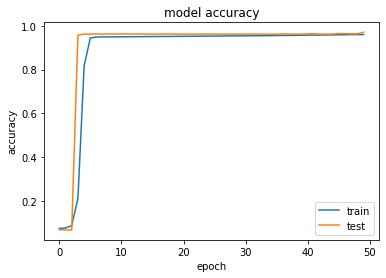

In [ ]:
target_names=['X','I','O','B']
 
y_pred=[]
y_true=[]

# Assign one-hot encodings to Y values (0,1,2,3 where 0 indicate the absence of words).
categorical_Y = to_categorical(Y)

X_statistic_train,X_statistic_test=X_stat,X_stat_Debater
X_simple_POS_train,X_simple_POS_test=X_simple_POS[train_set],X_simple_POS[test_set]
Y_train, Y_test = categorical_Y[train_set], categorical_Y[test_set]

# Train the model.
model=train_MultiModal(X_statistic_train,X_simple_POS_train,Y_train)

prediction=model.predict([X_statistic_test,X_simple_POS_test])
for i in range(len(Y_test)):
  y_pred+=np.argmax(prediction[i], axis = 1).tolist()
  y_true+=np.argmax(Y_test[i].tolist(), axis = 1).tolist()

In [ ]:
# Print the classification report of the result of the models created.
print(classification_report(y_true, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           X       1.00      1.00      1.00     98245
           I       0.94      0.44      0.60    160977
           O       0.11      0.72      0.19     15112
           B       0.00      0.00      0.00       562

    accuracy                           0.65    274896
   macro avg       0.51      0.54      0.45    274896
weighted avg       0.91      0.65      0.72    274896



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


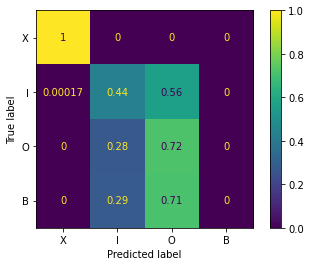

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()